<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Hawkes process simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import ks_2samp, kstest
from itertools import product

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import simulate_hawkes, simulate_hawkes_ogata, U_from_jumps, lam_from_jumps, N_from_jumps
from volterra_hawkes.utility.visualisation import Experiment, get_N_U_sample, get_arrivals_sample, plot_trajectories, plot_marginal_laws, poisson_jumps_test, plot_cf_convergence

from simulation.monte_carlo import MonteCarlo

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Visualisation of the trajectories

In [5]:
# mu = 3
# H = 0.3
# lam = 1
# c = 2
# alpha = 2

# T = 1
# n_steps = 1000

# rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
#K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)
# e = Experiment(
#     T=1,
#     n_steps = 250,
#     kernel = FractionalKernel(H=0.2, c=1),
#     mu=5
# )

# e = Experiment(
#     T=0.5,
#     n_steps = 10,
#     kernel = ConstantKernel(c=2),
#     mu=3
# )

# e = Experiment(
#     T=1,
#     n_steps = 1000,
#     kernel = ExponentialKernel(c=4, lam=5),
#     mu=10
# )
#
#

# lam_gamma = 20
# alpha_gamma = 4
# t0_gamma = (alpha_gamma - 1) / lam_gamma
# gamma_kernel = GammaKernel(lam=lam_gamma, alpha=alpha_gamma, c=lam_gamma**alpha_gamma)
# e = Experiment(
#     T=1,
#     n_steps = 1000,
#     kernel = gamma_kernel,
#     mu=10,
#     decreasing_kernel=lambda t: gamma_kernel(t) * (t > t0_gamma) + gamma_kernel(t0_gamma) * (t <= t0_gamma),
#     )
plt.plot(e.t_grid, e.kernel(e.t_grid))
plt.plot(e.t_grid, e.kernel.resolvent(e.t_grid))

plot_trajectories(e)


NameError: name 'e' is not defined

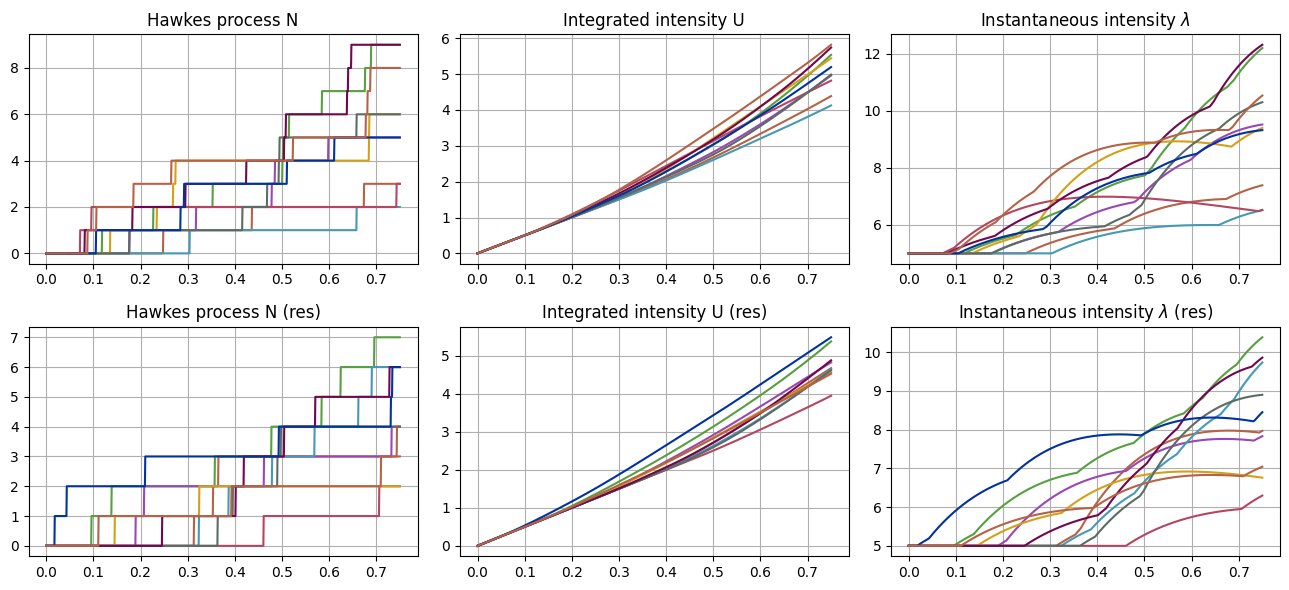

In [35]:
lam_gamma_3 = 3
alpha_gamma_3 = 2
t0_gamma_3 = (alpha_gamma_3 - 1) / lam_gamma_3
gamma_kernel_3 = GammaKernel(lam=lam_gamma_3, alpha=alpha_gamma_3, c=0.9 * lam_gamma_3 ** alpha_gamma_3)

e = Experiment(
    T=0.75,
    n_steps=1000,
    kernel=gamma_kernel_3,
    mu=5,
    decreasing_kernel=lambda t: gamma_kernel_3(t) * (t > t0_gamma_3) + gamma_kernel_3(t0_gamma_3) * (t <= t0_gamma_3),
)

plot_trajectories(e)

# Sanity check: $\mathbb{E}[N_T]$

In [7]:
lam_gamma_3 = 3
alpha_gamma_3 = 2
t0_gamma_3 = (alpha_gamma_3 - 1) / lam_gamma_3
gamma_kernel_3 = GammaKernel(lam=lam_gamma_3, alpha=alpha_gamma_3, c=0.9 * lam_gamma_3 ** alpha_gamma_3)

e=Experiment(
    T=1,
    n_steps=1000,
    kernel=gamma_kernel_3,
    mu=5,
    decreasing_kernel=lambda t: gamma_kernel_3(t) * (t > t0_gamma_3) + gamma_kernel_3(t0_gamma_3) * (t <= t0_gamma_3),
)

In [8]:
rng = np.random.default_rng(seed=42)
n_show = 100
n_paths = 10000

ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
ivi_hawkes_res = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar_res, g0_bar_res=e.g0_bar_res, rng=rng, g0=e.g0, resolvent_flag=True)

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)

expected_U = ivi_hawkes.U_mean(t_grid=e.t_grid)

hawkes_arrivals_sample = [simulate_hawkes(T=e.T, g0=e.g0, g0_upper_bound=e.mu, kernel=e.kernel, rng=rng) for _ in range(n_paths)]
N_T_sample = np.array([len(hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
U_sample = np.array([U_from_jumps(e.t_grid, hawkes_arrivals, e.kernel, e.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
expected_U_mc = np.mean(U_sample, axis = 0)

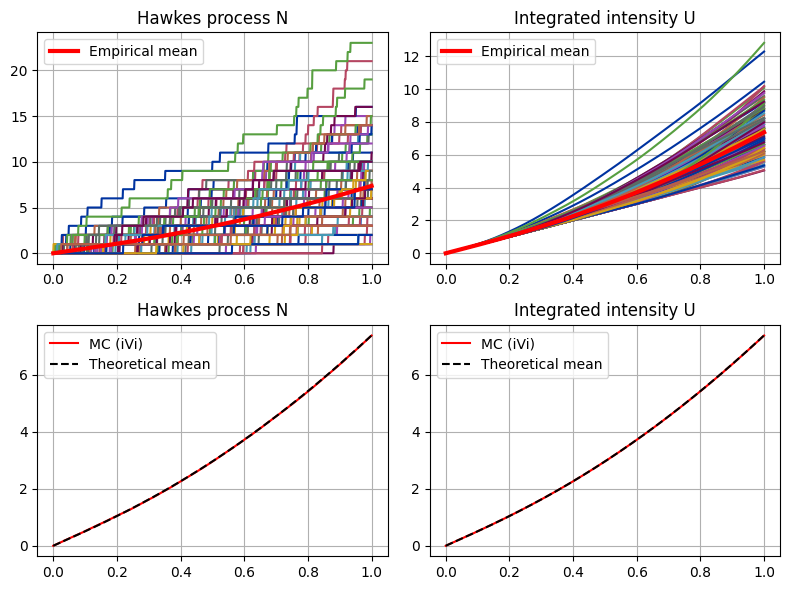

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(e.t_grid, N[:, 0:n_show])
ax[0, 0].plot(e.t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(e.t_grid, U[:,0:n_show])
ax[0, 1].plot(e.t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].legend()
ax[0, 1].grid("on")

# ax[1, 0].plot(e.t_grid, N_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 0].plot(e.t_grid, N.mean(axis=1), "r", label="MC (iVi)")
ax[1, 0].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process N')
ax[1, 0].legend()
ax[1, 0].grid("on")

# ax[1, 1].plot(e.t_grid, U_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 1].plot(e.t_grid, U.mean(axis=1), "r", label="MC (iVi)")
ax[1, 1].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
# ax[1, 1].plot(e.t_grid, expected_U_mc, label = "MC (exact)")
ax[1, 1].set_title('Integrated intensity U')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.savefig("Hawkes_mean.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

In [4]:
rng = np.random.default_rng(seed=42)
ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
expected_U = ivi_hawkes.U_mean(t_grid=e.t_grid)

expected_N_T = expected_U[-1]
expected_N_T

137.40164479245055

In [5]:
plt.plot(e.t_grid, np.abs(U_res.mean(axis = 1) - expected_U) / expected_U, label = "Res iVi")
plt.plot(e.t_grid, np.abs(U.mean(axis = 1) - expected_U) / expected_U, label = "iVi")
plt.plot(e.t_grid, np.abs(expected_U_mc - expected_U) / expected_U, label = "Exact")
plt.legend(loc=1)
plt.show()

NameError: name 'U_res' is not defined

# I. Marginal Laws of $N_T$ and $U_T$

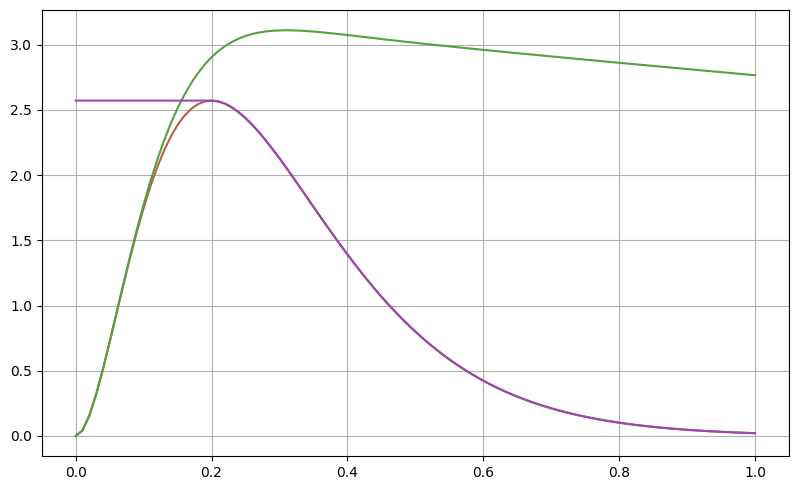

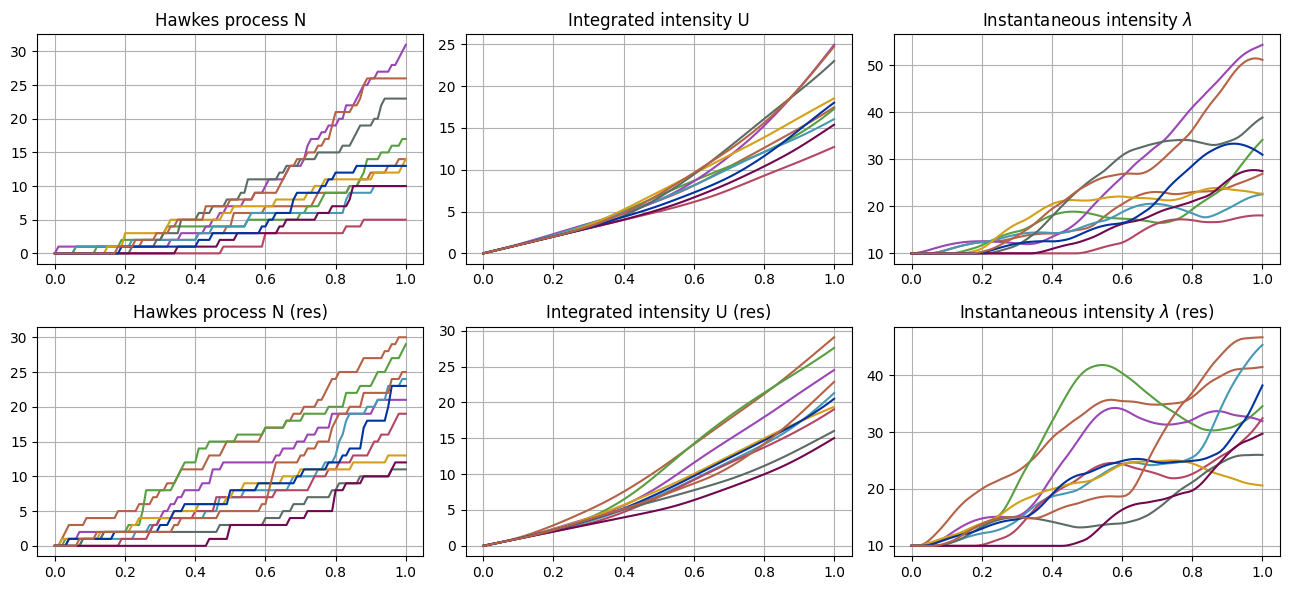

In [28]:
lam_gamma_2 = 10
alpha_gamma_2 = 3
t0_gamma_2 = (alpha_gamma_2 - 1) / lam_gamma_2
gamma_kernel_2 = GammaKernel(lam=lam_gamma_2, alpha=alpha_gamma_2, c=0.95 * lam_gamma_2 ** alpha_gamma_2)

e = Experiment(
    T=1,
    n_steps=100,
    kernel=gamma_kernel_2,
    mu=10,
    decreasing_kernel=lambda t: gamma_kernel_2(t) * (t > t0_gamma_2) + gamma_kernel_2(t0_gamma_2) * (t <= t0_gamma_2),
)

plt.plot(e.t_grid, e.kernel(e.t_grid))
plt.plot(e.t_grid, e.kernel.resolvent(e.t_grid))
plt.plot(e.t_grid, e.decreasing_kernel(e.t_grid))

plot_trajectories(e)

In [29]:
%%time

n_paths = 5_000

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in methods}

CPU times: total: 7.72 s
Wall time: 8 s


p-value Population-Ogata: 0.6945834812298466
p-value Population-iVi: 0.43549127415019256
p-value Population-Res iVi: 0.1856663803254565


{'Population-Ogata': (0.6945834812298466, 0.0142),
 'Population-iVi': (0.43549127415019256, 0.0174),
 'Population-Res iVi': (0.1856663803254565, 0.0218)}

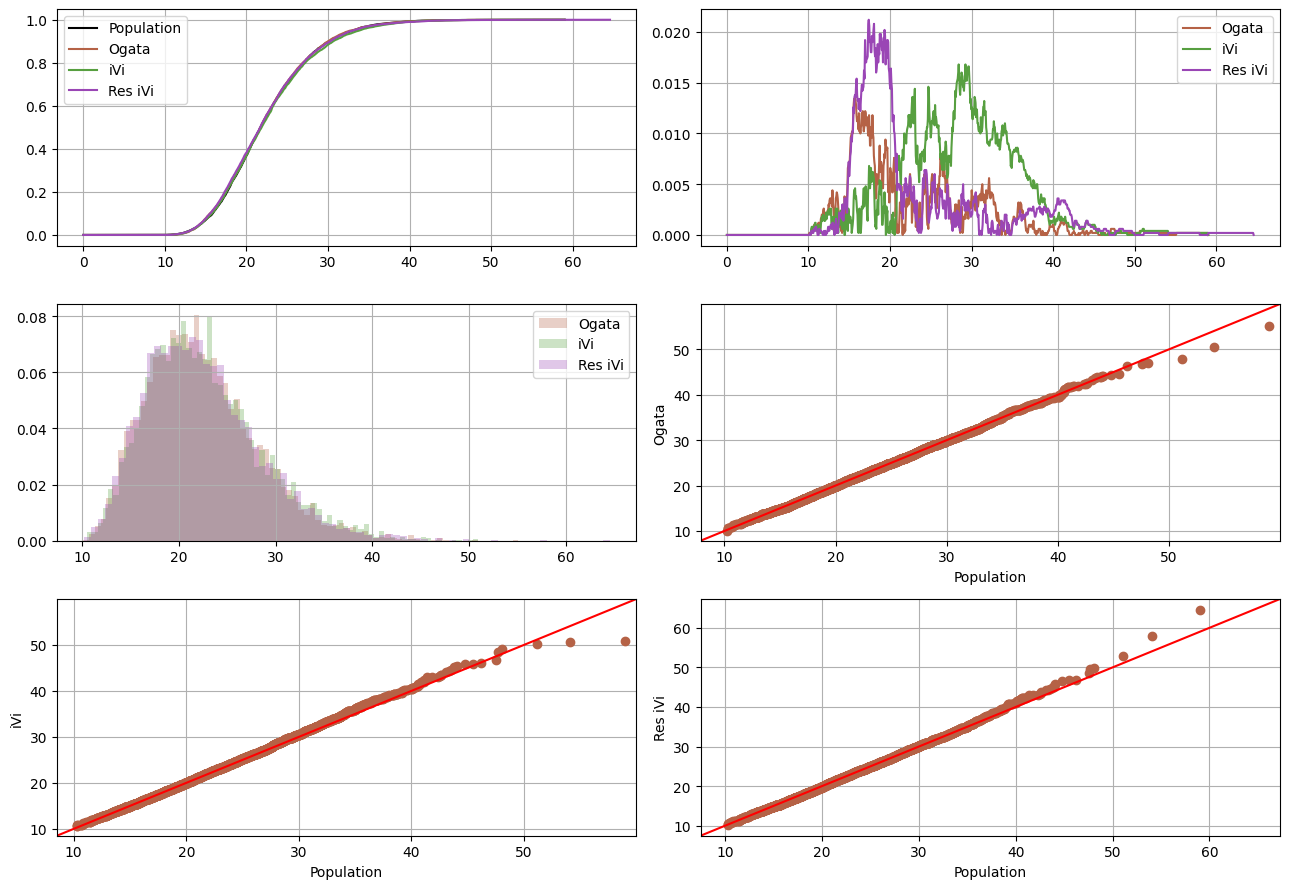

In [30]:
plot_marginal_laws(samples, "U")

p-value Population-Ogata: 0.10740980185915357
p-value Population-iVi: 0.0038596010962783566
p-value Population-Res iVi: 0.022340230544746754


{'Population-Ogata': (0.10740980185915357, 0.0171),
 'Population-iVi': (0.0038596010962783566, 0.025),
 'Population-Res iVi': (0.022340230544746754, 0.0212)}

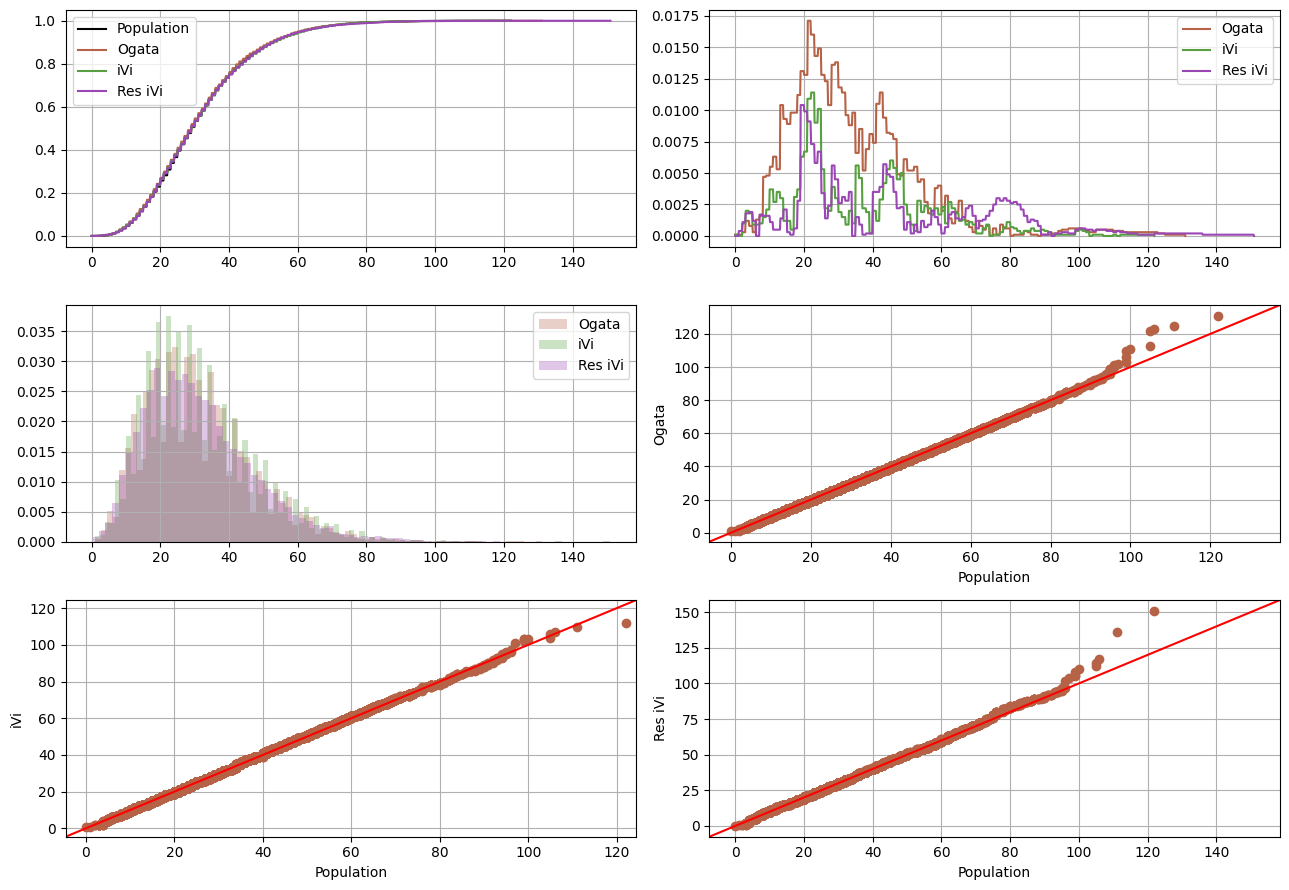

In [113]:
plot_marginal_laws(samples, "N")

p-value Population-Ogata: 0.734599370602186


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value Population-iVi: 0.9212790168134688


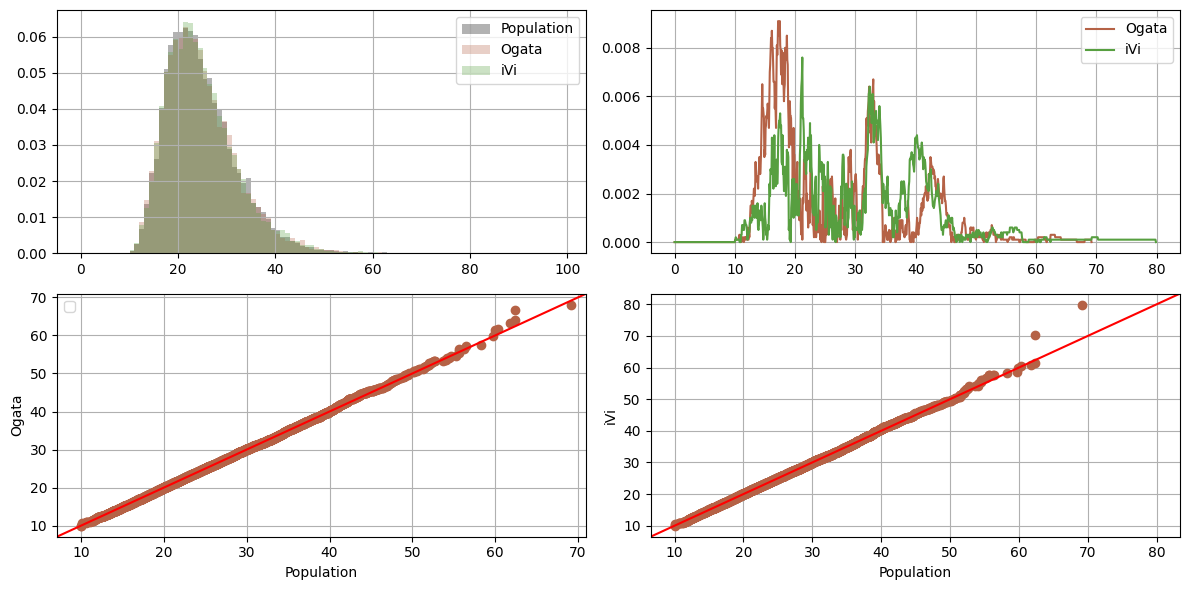

### Convergence rate

In [18]:
%%time

methods = ["iVi", "Res iVi"]
n_steps_arr = [20, 35, 50, 65, 80, 100, 200, 500, 750, 1000]
n_paths = 1_000_000

experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]

# samples = {(method, e.n_steps): get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method, e in product(methods, experiments)}

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
methods_non_ivi = ["Population", "Ogata"]
n_paths_non_ivi = 10_000
samples_non_ivi = {method: get_N_U_sample(experiment=experiments[-1], method=method, n_paths=n_paths_non_ivi, return_counters=True) for method in methods_non_ivi}

CPU times: total: 10.8 s
Wall time: 18.8 s


In [20]:
w = -1 / expected_N_T
fun = lambda x: np.exp(w * x)

cf_ref = {}

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0

    rng = np.random.default_rng(seed=42)
    ivi = IVIHawkesProcess(kernel=experiments[-1].kernel, g0_bar=experiments[-1].g0_bar, rng=rng, g0=experiments[-1].g0, resolvent_flag=False)
    cf_ref[mode] = ivi.characteristic_function(T=experiments[-1].T, w=w, n_steps=10000, mode=mode)

In [25]:
mc_cf = {}
methods = ["iVi", "Res iVi"]
n_steps_arr = [20, 35, 50, 65, 80, 100, 200, 500, 750, 1000]
batch_size = 100_000
n_batch = 10
n_paths = n_batch * batch_size

experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]
mc_samples = dict()

for method, experiment in product(methods, experiments):
    print(experiment.n_steps)
    rng = np.random.default_rng(seed=42)
    for _ in range(n_batch):
        sample = get_N_U_sample(experiment=experiment, method=method, n_paths=batch_size, rng=rng, return_counters=True)
        for mode in ["U", "N"]:
            idx = 1 if mode == "U" else 0
            if (method, experiment.n_steps, mode) not in mc_samples:
                mc_samples[(method, experiment.n_steps, mode)] = MonteCarlo(batch=fun(sample[idx][:, -1]), confidence_level=0.95)
            else:
                mc_samples[(method, experiment.n_steps, mode)].add_batch(batch=fun(sample[idx][:, -1]))

20
35
50
65
80
100
200
500
750
1000
20
35
50
65
80
100
200
500
750
1000


Reference value: 0.836485809483763
Reference value: 0.8383602684289374


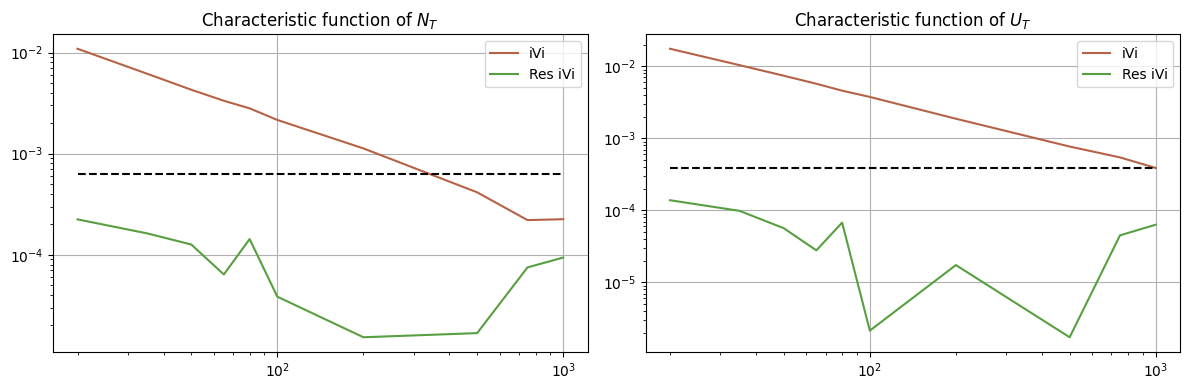

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

errors_ivi = {}
for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    print("Reference value:", cf_ref[mode])

    mc_std = np.sqrt(mc_samples[('Res iVi', n_steps_arr[-1], mode)].var / n_paths)

    errors_ivi[mode] = {}
    methods = ["iVi", "Res iVi"]

    for method in methods:
        errors_ivi[mode][method]  = []
        for experiment in experiments:
            # U = samples[(method, e.n_steps)][idx]
            errors_ivi[mode][method].append(np.abs(cf_ref[mode] - mc_samples[(method, experiment.n_steps, mode)].mean))
        ax[idx].loglog(n_steps_arr, errors_ivi[mode][method], label=method)
    ax[idx].hlines(y=3 * mc_std, xmin=n_steps_arr[0], xmax=n_steps_arr[-1], color="k", linestyles="--")
    ax[idx].set_title(f"Characteristic function of ${mode}_T$")
    ax[idx].legend()

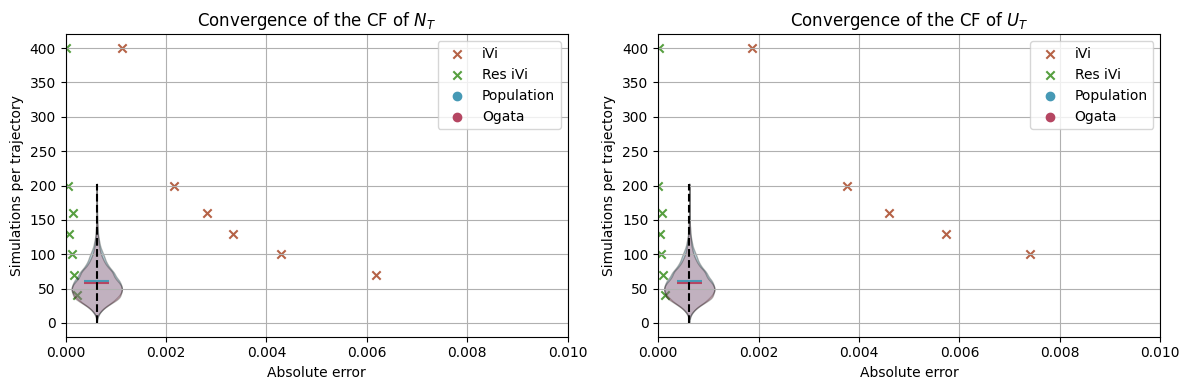

In [23]:
fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    ax = ax_arr[idx]
    for method in methods:
        ax.scatter(errors_ivi[mode][method], 2 * np.array(n_steps_arr), marker="x", label=method)

    for method, color in zip(methods_non_ivi, color_cycle[3:]):
        error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
        parts= ax.violinplot(samples_non_ivi[method][2], positions=[3*mc_std], widths=0.001, showmeans=True, showextrema=False)
        ax.scatter([], [], c=color, label=method)
        for pc in parts['bodies']:
            pc.set_facecolor(color)  # blue fill
            pc.set_edgecolor('black')    # black outline
        parts['cmeans'].set_color(color)

    ax.vlines(x=3*mc_std, ymin=0, ymax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")

    ax.legend()
    ax.set_xlim([0, 0.01])
    ax.set_xlabel("Absolute error")
    ax.set_ylabel("Simulations per trajectory")
    ax.set_title(f"Convergence of the CF of ${mode}_T$")

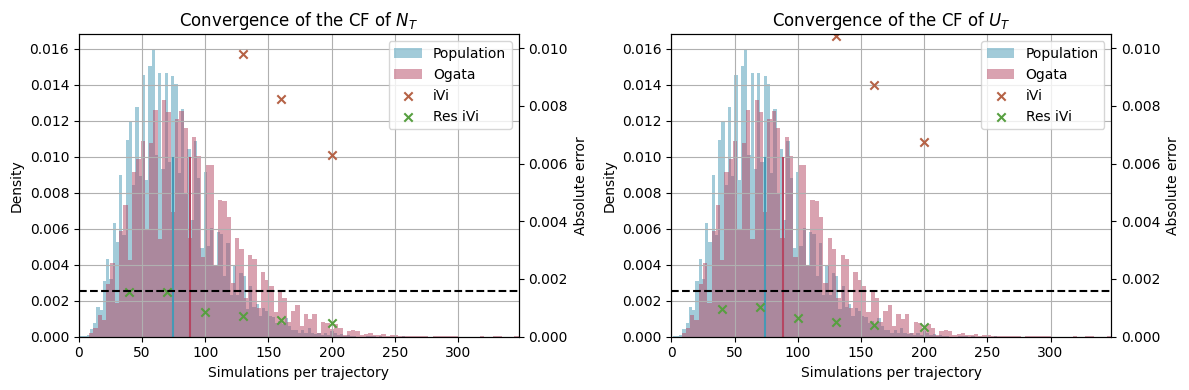

In [26]:
fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    ax = ax_arr[idx]

    for method, color in zip(methods_non_ivi, color_cycle[3:]):
        error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
        ax.hist(samples_non_ivi[method][2], color=color, label=method, density=True, bins=100, alpha=0.5)
        ax.vlines(np.mean(samples_non_ivi[method][2]), 0, 0.01, color=color)

    ax.set_xlim([0, np.max(samples_non_ivi["Ogata"][2])])

    # Create second y-axis
    ax2 = ax.twinx()

    for method in methods:
        ax2.scatter(2 * np.array(n_steps_arr), errors_ivi[mode][method],  marker="x", label=method)

    ax2.hlines(y=3*mc_std, xmin=0, xmax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")
    ax2.set_ylim([0, 20*mc_std])


    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2)
    ax2.grid(False)

    ax.set_xlabel("Simulations per trajectory")
    ax.set_ylabel("Density")

    # ax.set_xlim([0, 0.01])
    ax2.set_ylabel("Absolute error")
    ax.set_title(f"Convergence of the CF of ${mode}_T$")

# II. Distribution of arriavals

## Simulation of arrivals

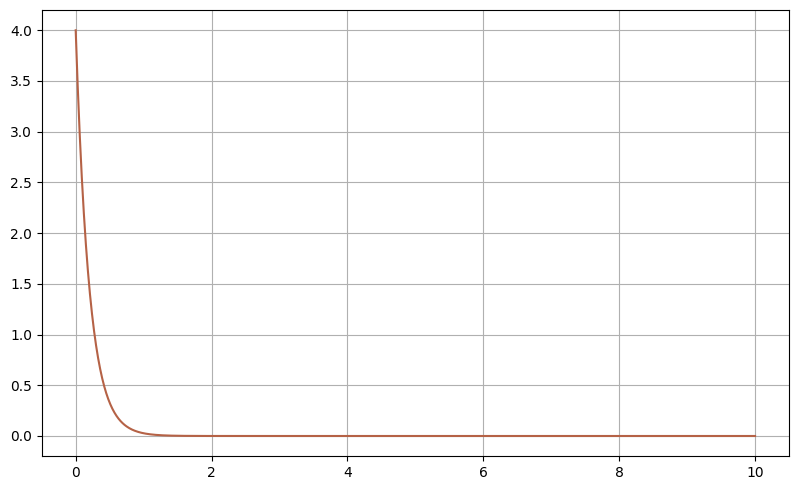

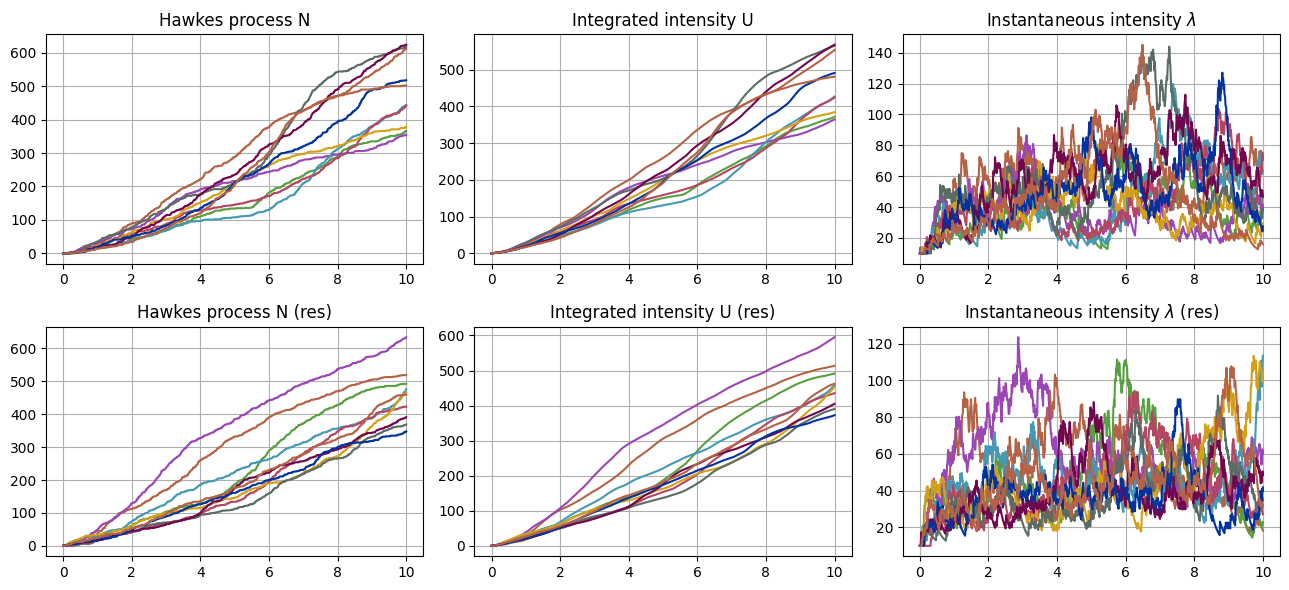

In [46]:
# H = 0.3
# lam = 1.1
# c = 1
# alpha = 2.5

# T = 10
# n_steps = 100
# n_paths = 1

# t_grid = np.linspace(0, T, n_steps + 1)

# rng = np.random.default_rng(seed = 42)


# # K = FractionalKernel(H=H, c=c)
# K = ExponentialKernel(lam=lam, c=c)
# K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)

# e = Experiment(
#     T=10,
#     n_steps=1,
#     kernel=ExponentialKernel(lam=1.1, c=1),
#     mu=3
# )

# e = Experiment(
#     T=6,
#     n_steps=20,
#     kernel=FractionalKernel(H=0.2, c=0.7),
#     mu=3
# )

e = Experiment(
    T=10,
    n_steps = 1000,
    kernel = ExponentialKernel(c=4, lam=5),
    mu=10
)

plt.plot(e.t_grid, e.kernel(e.t_grid))
plot_trajectories(e)

Population
Kolmogorov-Smirnov test p-value:  0.14289882224580774
Ogata
Kolmogorov-Smirnov test p-value:  0.5329244487250036
iVi
Kolmogorov-Smirnov test p-value:  0.8097022049731294


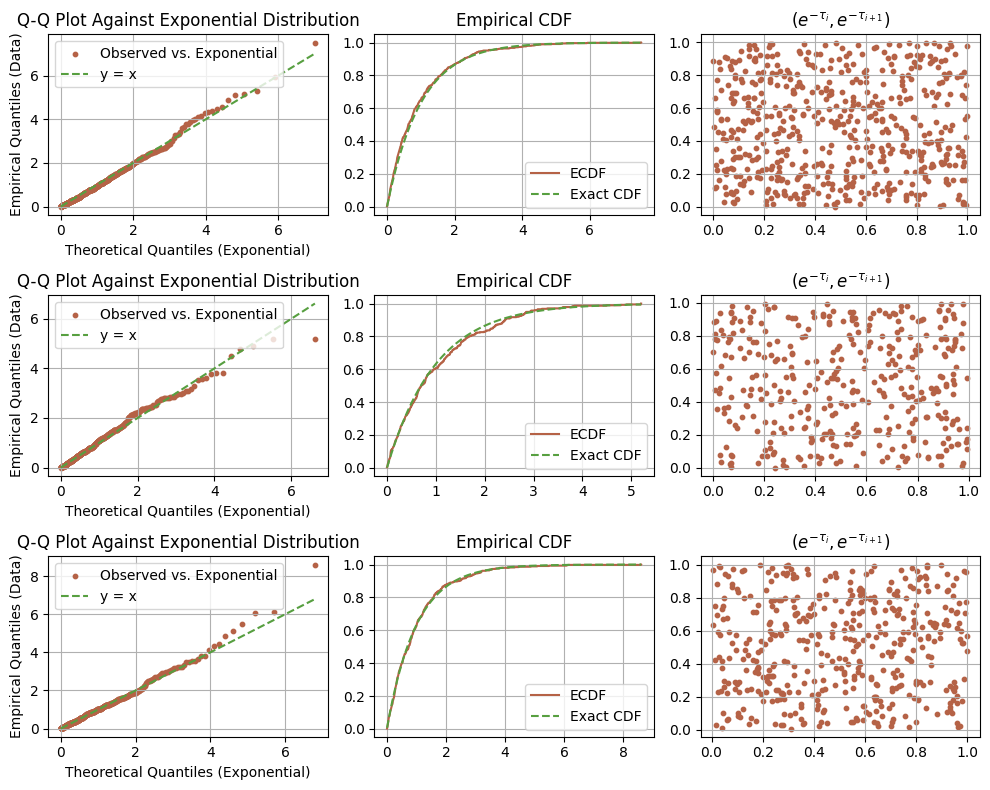

In [45]:
rng = np.random.default_rng(seed=42)
methods = ["Population", "Ogata", "iVi"]

fig, axes = plt.subplots(3, 3, figsize=(10, 8))

for method, ax in zip(methods, axes):
    samples_arrivals = get_arrivals_sample(experiment=e, method=method, n_paths=1, rng=rng)
    print(method)
    ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0, resolvent_flag=False)
    poisson_jumps_test(ivi_hawkes.U_from_jumps(samples_arrivals[0], samples_arrivals[0]), ax=ax, fig=fig, path="./arraivals_exp.pdf")

Gamma kernel

In [4]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=GammaKernel(alpha=2, lam=3, c=8.1), mu=5)_2025-08-28_10_09_30/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi'], 'methods_non_ivi': ['Population', 'Ogata'], 'n_paths_time_meas': 100000, 'n_steps_arr_cf': [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000], 'n_batch_cf': 10, 'batch_size_cf': 100000, 'n_paths_non_ivi': 10000, 'time_Population': 84.45497035980225, 'time_Ogata': 91.36264324188232, 'mean_N_T': 7.37231604438123, 'U_p_values_10': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [1.5282513643318188e-42, 0.0984]}, 'N_p_values_10': {'Population-Ogata': [0.031162582913927636, 0.0204], 'Population-iVi': [1.044038376030117e-22, 0.0716]}, 'U_p_values_50': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [0.014473851205715274, 0.0222]}, 'N_p_values_50': {'Population-Ogata': [0.031162582913927636, 0.0204], 'Population-iVi': [4.585036479758856e-26, 0.0768]}, 'U_p_values_100': {'Population-Ogata': [0.11890214798175557, 0.0168], 'Population-iVi': [0.21692483428445863, 0.0149]}, 'N_p_values_100': {'Population-Ogata': [0.0311625829139

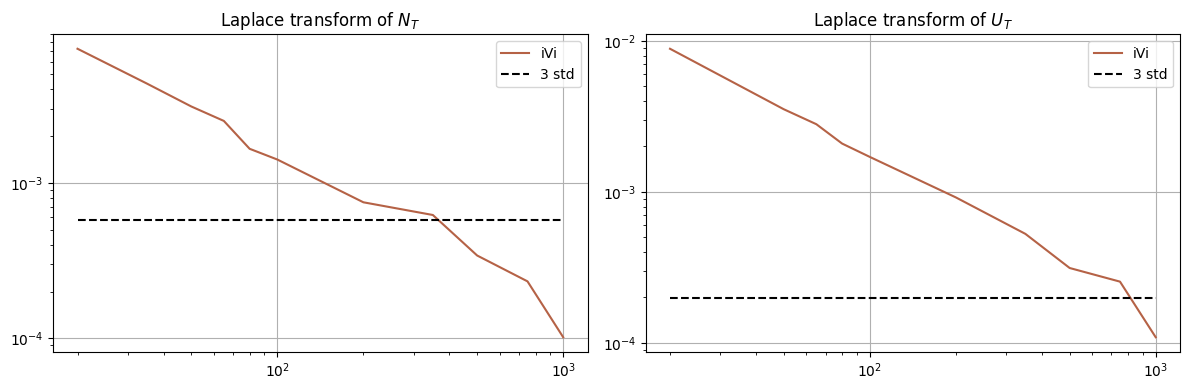

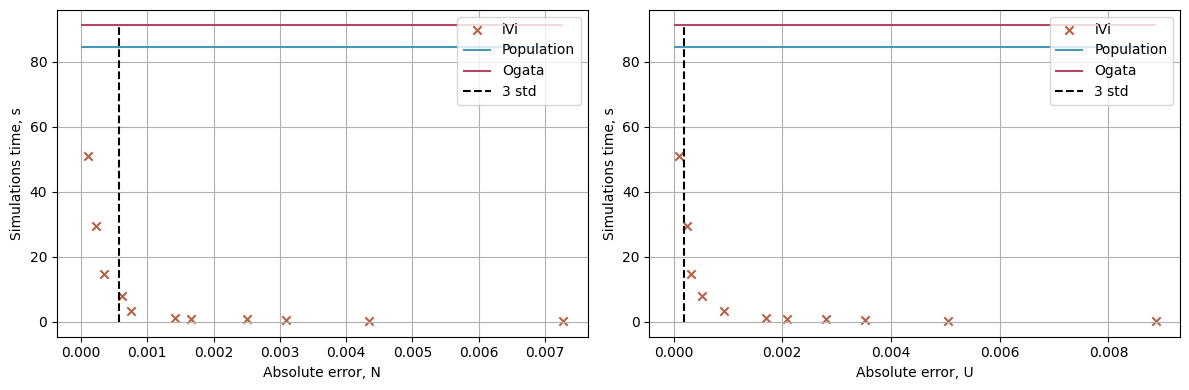

In [6]:
plot_cf_convergence(results=results, path_experiment="./gamma_article/")

In [26]:
%%time

n_paths = 10_000

e = Experiment(T=1, n_steps=100, kernel=GammaKernel(alpha=2, lam=3, c=8.1), mu=5)

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in methods}

CPU times: total: 6.53 s
Wall time: 7.16 s


p-value Population-Ogata: 0.11890214798175557
p-value Population-iVi: 0.21692483428445863
p-value Population-Ogata: 0.031162582913927636
p-value Population-iVi: 0.22343759648123543


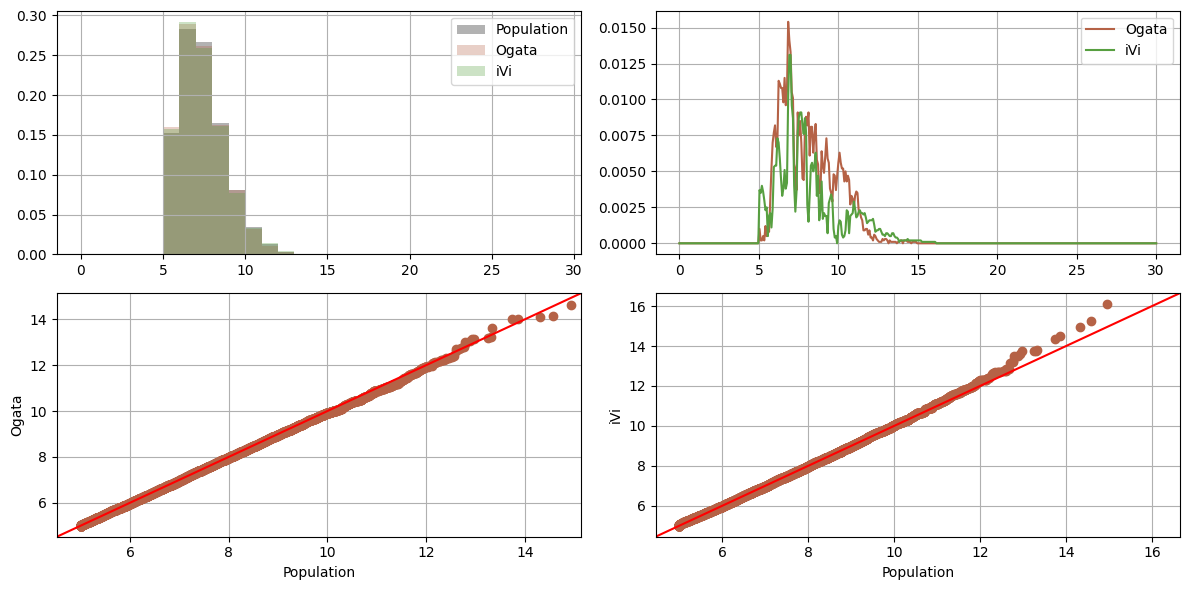

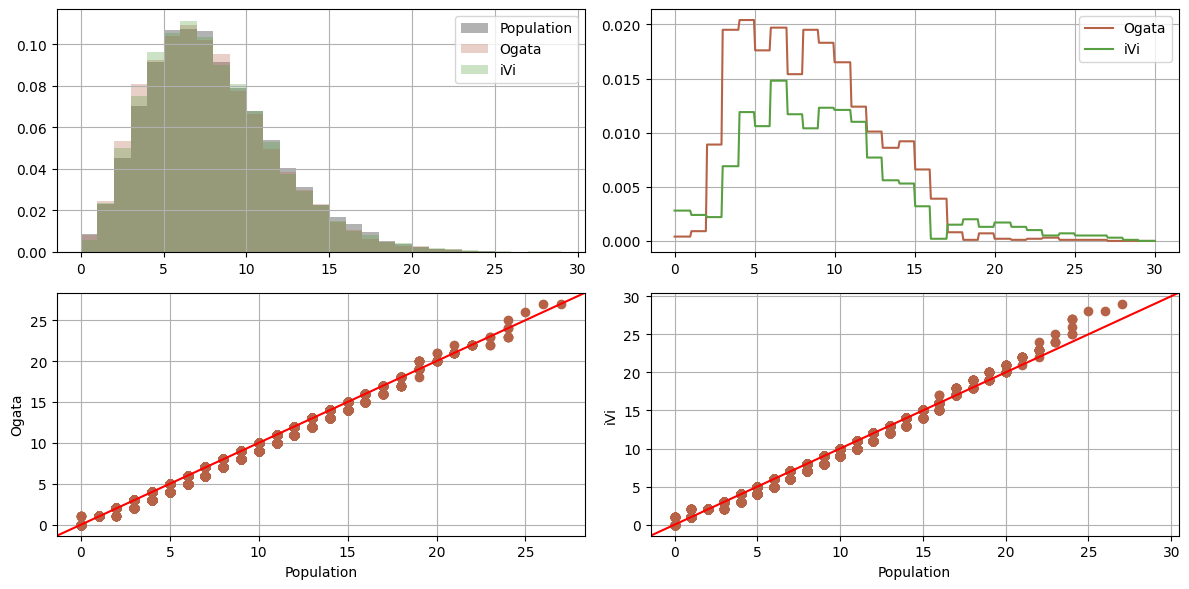

In [30]:
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import ks_2samp, kstest
from scipy.stats import expon
import statsmodels.api as sm

x_grid = np.linspace(0, 30, 400)
bins = np.arange(30)


for flag in ["U", "N"]:
    methods = results["methods_non_ivi"] + results["methods_ivi"]

    if flag == "N":
        idx = 0
    elif flag == "U":
        idx = 1
    else:
        raise ValueError("flag must be 'N' or 'U'")

    fig, ax = plt.subplots(2, 2, figsize=(12, 6))

    X_T_exact = samples["Population"][idx][:, -1]
    # x_grid = np.linspace(0, np.max(X_T_exact), 500)
    ecdf_exact = sm.distributions.ECDF(samples["Population"][idx][:, -1])
    # ax[0, 0].plot(x_grid, ecdf_exact(x_grid), label=methods[0], color="k")
    ax[0, 0].hist(samples["Population"][idx][:, -1], density=True, bins=bins, alpha=0.3, color="k", label=methods[0])

    p_values_dict = dict()
    for method, ax_qq in zip(methods[1:], [ax[1, 0], ax[1, 1]]):
        X_T = samples[method][idx][:, -1]
        if flag == "N":
            X_T = np.round(X_T)
        ecdf = sm.distributions.ECDF(X_T)
        # x_grid = np.linspace(2, 4, 1000)
        # x_grid = np.linspace(0, max(np.max(X_T), np.max(X_T_exact)), 1000)
        # ax[0, 0].plot(x_grid, ecdf(x_grid), label=method)
        ax[0, 0].hist(X_T, density=True, bins=bins, alpha=0.3, label=method)
        ax[0, 1].plot(x_grid, np.abs(ecdf(x_grid) - ecdf_exact(x_grid)), label=method)
        # print(method, np.max(np.abs(ecdf(x_grid) - ecdf_exact(x_grid))))
        qqplot_2samples(sm.ProbPlot(X_T_exact), sm.ProbPlot(X_T), ax=ax_qq, xlabel="Population", ylabel=method,
                        line="45")

        print(f"p-value Population-{method}:", ks_2samp(X_T, X_T_exact).pvalue)
        # print(ks_2samp(X_T, X_T_exact))
        p_values_dict[f"Population-{method}"] = ks_2samp(X_T, X_T_exact).pvalue, ks_2samp(X_T, X_T_exact).statistic

    ax[0, 0].legend()
    ax[0, 1].legend()

    # if path is not None:
    fig.savefig(fname="./gamma_article/marginal_laws_" + flag + ".pdf", format="pdf", bbox_inches="tight", transparent=True)

## Fractional

In [31]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=FractionalKernel(c=0.7696136340726079, H=0.1), mu=150)_2025-08-27_05_55_03_full_res_million/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi', 'Res iVi'], 'methods_non_ivi': ['Population', 'Ogata'], 'n_paths_time_meas': 100000, 'n_paths_non_ivi': 10000, 'time_Population': 1179.8014450073242, 'time_Ogata': 2175.1196026802063, 'mean_N_T': 288.1422726513042, 'U_p_values_10': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [0.0, 0.5907], 'Population-Res iVi': [0.42554664596413133, 0.0124]}, 'N_p_values_10': {'Population-Ogata': [0.31338762324335184, 0.0136], 'Population-iVi': [1e-323, 0.3279], 'Population-Res iVi': [0.1449137168873294, 0.0162]}, 'U_p_values_50': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [2.7391559486243423e-88, 0.142], 'Population-Res iVi': [0.5342696653345376, 0.0114]}, 'N_p_values_50': {'Population-Ogata': [0.31338762324335184, 0.0136], 'Population-iVi': [4.664971860248842e-21, 0.0689], 'Population-Res iVi': [0.175326677835407, 0.0156]}, 'U_p_values_100': {'Population-Ogata': [0.6160853764303585, 0.0107], 'Population-iVi': [8.71093747381464

In [36]:
results['time_Population'] / results['time_Res iVi_20']

4238.986647967007

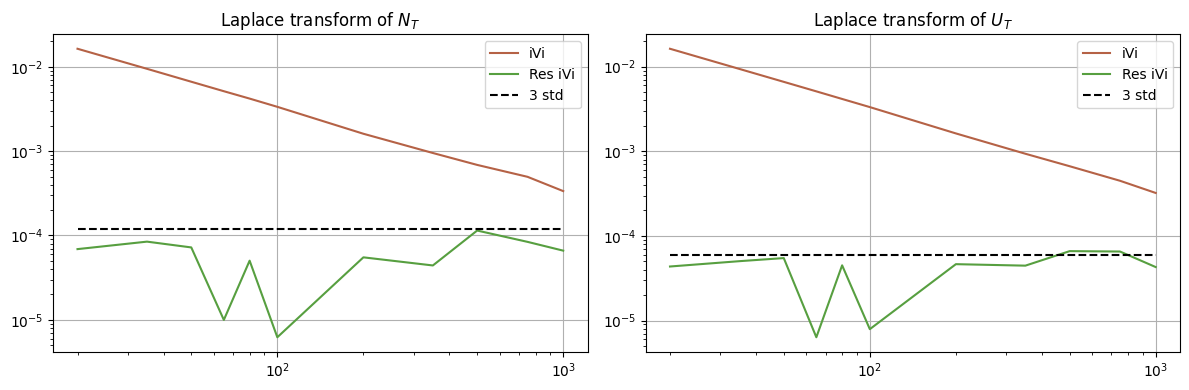

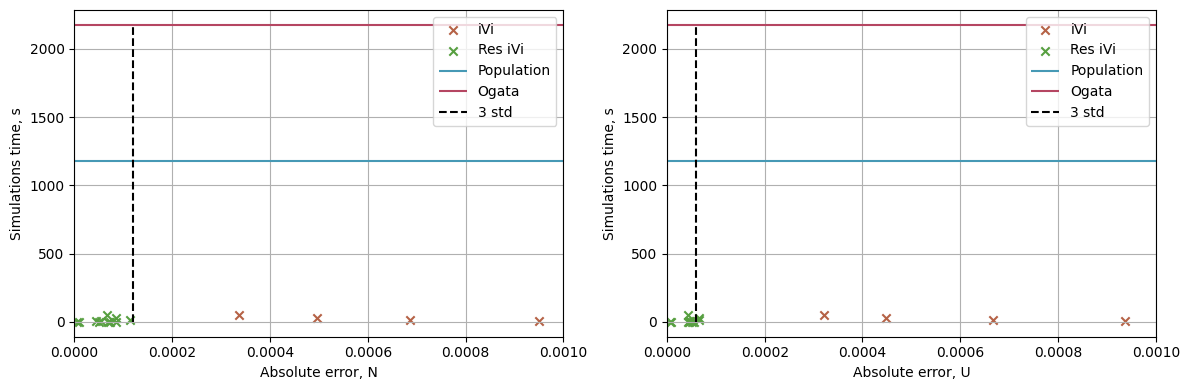

In [34]:
plot_cf_convergence(results=results, path_experiment="./fractional_article/", x_lim=[0, 0.001])

## Fractional

In [37]:
import json

with open('../experiments/Experiment(T=1, n_steps=1000, kernel=ExponentialKernel(c=8, lam=10), mu=20)_2025-08-27_20_02_44_exp_2000_steps/results.json') as f:
    results = json.load(f)
    print(results)

{'methods_ivi': ['iVi', 'Res iVi'], 'methods_non_ivi': ['ExpExact', 'Ogata'], 'n_paths_time_meas': 100000, 'n_steps_arr_cf': [20, 35, 50, 65, 80, 100, 200, 350, 500, 750, 1000, 2000], 'n_batch_cf': 10, 'batch_size_cf': 100000, 'n_paths_non_ivi': 10000, 'time_ExpExact': 157.00987339019775, 'time_Ogata': 237.8031039237976, 'mean_N_T': 65.33336952141568, 'U_p_values_10': {'ExpExact-Ogata': [0.7229401381401557, 0.0098], 'ExpExact-iVi': [1e-323, 0.2907], 'ExpExact-Res iVi': [0.04126178292409227, 0.0197]}, 'N_p_values_10': {'ExpExact-Ogata': [0.6398931694241892, 0.0105], 'ExpExact-iVi': [9.610020744831768e-203, 0.215], 'ExpExact-Res iVi': [0.01512953257863315, 0.0221]}, 'U_p_values_50': {'ExpExact-Ogata': [0.7229401381401557, 0.0098], 'ExpExact-iVi': [3.603088566507035e-18, 0.0639], 'ExpExact-Res iVi': [0.31338762324335184, 0.0136]}, 'N_p_values_50': {'ExpExact-Ogata': [0.6398931694241892, 0.0105], 'ExpExact-iVi': [3.7805627315956485e-14, 0.0562], 'ExpExact-Res iVi': [0.042915742476880514, 0

In [38]:
results['time_ExpExact'] / results['time_Res iVi_20']

561.0341816170651

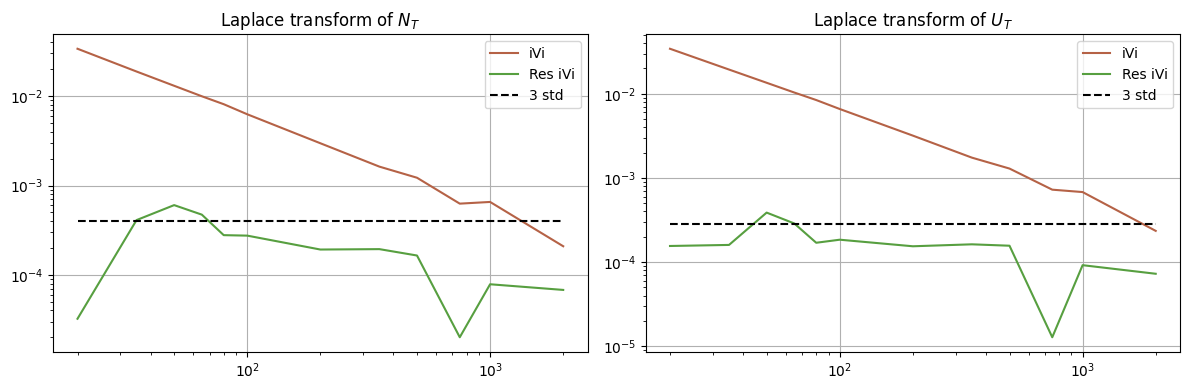

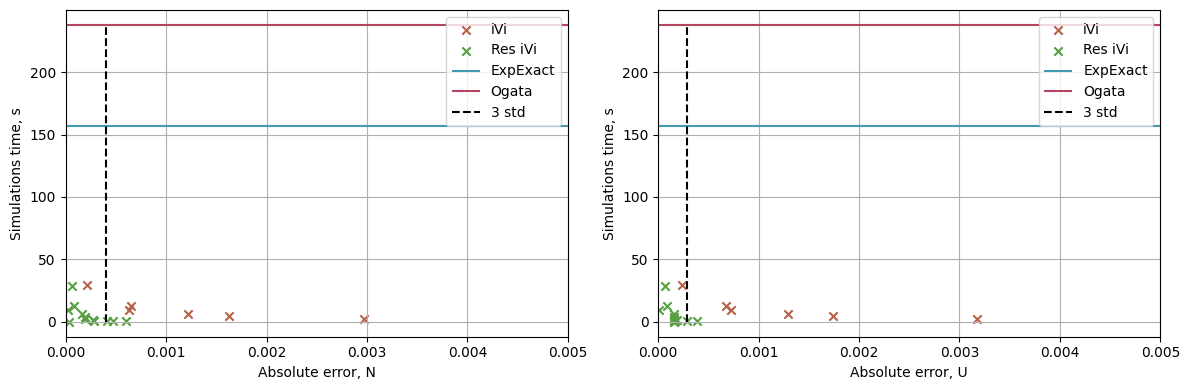

In [40]:
plot_cf_convergence(results=results, path_experiment="./exponential_article/", x_lim=[0, 0.005])